# CSE 151B Kaggle Competition

In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import ast
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from datetime import datetime
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import scipy.stats as stats
import geopandas as gpd
from shapely.geometry import LineString
from sklearn.preprocessing import OneHotEncoder

In [2]:
df_tr = pd.read_csv("train.csv")

# EDA and Feature Engineering

In [3]:
# dropping small amount of data with incomplete gps data since there isn't much
num_missing = df_tr['MISSING_DATA'].value_counts()[True]
percent = 100*(df_tr['MISSING_DATA'].value_counts()[True] / len(df_tr))
print('Percentage of MISSING_DATA = True is {:.5f}'.format(percent))
df_tr = df_tr[df_tr['MISSING_DATA']==False]

Percentage of MISSING_DATA = True is 0.00058


In [4]:
df_tr["DAY_TYPE"].describe() # Only has one unique value so we can drop the column
df_tr.drop('DAY_TYPE', axis=1, inplace=True)

In [5]:
is_duplicate = df_tr.duplicated(keep=False)

# Get the duplicate rows
duplicate_rows = df_tr[is_duplicate]

print("Duplicate rows:")
print(duplicate_rows)
print("Number of duplicate rows")
#drop them
df_tr.drop_duplicates(inplace=True)

Duplicate rows:
                     TRIP_ID CALL_TYPE  ORIGIN_CALL  ORIGIN_STAND   TAXI_ID  \
302435   1378607552620000403         C          NaN           NaN  20000403   
302441   1378607552620000403         C          NaN           NaN  20000403   
998727   1391416612620000196         C          NaN           NaN  20000196   
998728   1391416612620000196         C          NaN           NaN  20000196   
1304114  1397172149620000454         C          NaN           NaN  20000454   
1304115  1397172149620000454         C          NaN           NaN  20000454   

          TIMESTAMP  MISSING_DATA  \
302435   1378607552         False   
302441   1378607552         False   
998727   1391416612         False   
998728   1391416612         False   
1304114  1397172149         False   
1304115  1397172149         False   

                                                  POLYLINE  
302435                                                  []  
302441                                          

In [6]:
# Estimating trip length from Polyline
def polyline_to_trip_duration(polyline):
    return max(polyline.count("[") - 2, 0) * 15

# This code creates a new column, "LEN", in our dataframe. The value is
# the (polyline_length - 1) * 15, where polyline_length = count("[") - 1
df_tr["LEN"] = df_tr["POLYLINE"].apply(polyline_to_trip_duration)

In [7]:
# checking how many trips have time of 0 and dropping
percent_zero = 100*(len(df_tr[df_tr['LEN'] == 0]) / len(df_tr))
print("Percentage of trips with zero travel time is {:.2f}%".format(percent_zero))
df_tr = df_tr[df_tr["LEN"]!= 0] #dropping any trips with travel time of zero

Percentage of trips with zero travel time is 2.13%


In [8]:
def parse_time(x):
  # We are using python's builtin datetime library
  # https://docs.python.org/3/library/datetime.html#datetime.date.fromtimestamp
  # Each x is essentially a 1 row, 1 column pandas Series
    dt = datetime.fromtimestamp(x["TIMESTAMP"])
    return dt.year, dt.month, dt.day, dt.hour, dt.weekday()

# Because we are assigning multiple values at a time, we need to "expand" our computed (year, month, day, hour, weekday) tuples on 
# the column axis, or axis 1
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html
df_tr[["YR", "MON", "DAY", "HR", "WK"]] = df_tr[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")

In [9]:
df_tr.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,MISSING_DATA,POLYLINE,LEN,YR,MON,DAY,HR,WK
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",330,2013,7,1,0,0
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",270,2013,7,1,0,0
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",960,2013,7,1,0,0
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",630,2013,7,1,0,0
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",420,2013,7,1,0,0


In [10]:
df_tr.groupby('ORIGIN_CALL', dropna=False)['LEN'].agg(['mean', 'std', 'count']).sort_values(by='count', ascending=False).head(50)

,mean,std,count
ORIGIN_CALL,,,
NaN,725.811344,724.799386,1311435
2002.0,845.920673,585.461300,57257
63882.0,777.582392,517.137932,6372
2001.0,753.014888,621.527065,2418
13168.0,898.156489,606.866725,1310
6728.0,926.956522,617.959107,1104
5591.0,948.835878,496.751799,1048
14123.0,857.588832,531.316673,985
6654.0,1217.591362,1031.203517,903


In [11]:
df_tr.groupby('ORIGIN_STAND', dropna=False)['LEN'].agg(['mean', 'std', 'count']).sort_values(by='count', ascending=False).head(50)

,mean,std,count
ORIGIN_STAND,,,
NaN,787.353425,823.813088,876465
15.0,789.996610,561.479750,79653
57.0,673.107365,512.217786,50184
9.0,767.548943,621.952799,34479
33.0,725.754088,423.130028,33756
23.0,600.381894,378.588828,33072
18.0,724.755952,424.984411,32596
53.0,637.908575,501.963254,31206
13.0,619.217113,539.995908,25489


In [12]:
total_counts = df_tr.groupby("TAXI_ID").size()
missing_counts = df_tr[df_tr["ORIGIN_STAND"].isnull()].groupby("TAXI_ID").size()
((missing_counts/total_counts)*100).fillna(0).sort_values(ascending=False).head(50)

TAXI_ID
20000981    100.000000
20000969    100.000000
20000941    100.000000
20000467     94.702348
20000607     83.347639
20000534     82.254197
20000665     80.063923
20000312     79.794521
20000036     78.961900
20000670     78.020776
20000279     77.673410
20000601     76.697213
20000509     75.618698
20000037     75.592928
20000529     75.498411
20000276     74.621473
20000172     74.514945
20000610     74.277457
20000205     74.130106
20000163     73.726852
20000616     72.390214
20000693     72.257323
20000304     72.179628
20000432     71.626984
20000076     71.565378
20000346     71.551724
20000668     71.537002
20000108     71.326837
20000657     70.650496
20000488     70.595855
20000574     70.574203
20000080     70.523892
20000395     70.027347
20000112     69.531996
20000569     69.077118
20000372     68.188348
20000363     68.044921
20000077     67.567568
20000901     67.466478
20000337     67.383898
20000207     66.464156
20000520     66.326531
20000688     66.252624
200

In [13]:
df_tr['TAXI_ID'].nunique()

442

In [14]:
# statistics of non_categorical columns
df_tr.describe() 

,TRIP_ID,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,LEN,YR,MON,DAY,HR,WK
count,1.674151e+06,362716.000000,797686.000000,1.674151e+06,1.674151e+06,1.674151e+06,1.674151e+06,1.674151e+06,1.674151e+06,1.674151e+06,1.674151e+06
mean,1.388600e+18,24492.082679,30.250048,2.000035e+07,1.388600e+09,7.320456e+02,2.013497e+03,6.592457e+00,1.559815e+01,1.191345e+01,3.057916e+00
std,9.191946e+15,19624.567796,17.736708,2.108916e+02,9.191946e+06,6.838430e+02,4.999904e-01,3.406837e+00,8.844500e+00,6.234943e+00,1.967695e+00
min,1.372637e+18,2001.000000,1.000000,2.000000e+07,1.372637e+09,1.500000e+01,2.013000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,1.380707e+18,6598.000000,15.000000,2.000017e+07,1.380707e+09,4.200000e+02,2.013000e+03,4.000000e+00,8.000000e+00,7.000000e+00,1.000000e+00
50%,1.388440e+18,18755.000000,27.000000,2.000034e+07,1.388440e+09,6.150000e+02,2.013000e+03,7.000000e+00,1.500000e+01,1.200000e+01,3.000000e+00
75%,1.396749e+18,40809.250000,49.000000,2.000052e+07,1.396749e+09,8.700000e+02,2.014000e+03,1.000000e+01,2.300000e+01,1.700000e+01,5.000000e+00
max,1.404173e+18,63884.000000,63.000000,2.000098e+07,1.404173e+09,5.820000e+04,2.014000e+03,1.200000e+01,3.100000e+01,2.300000e+01,6.000000e+00


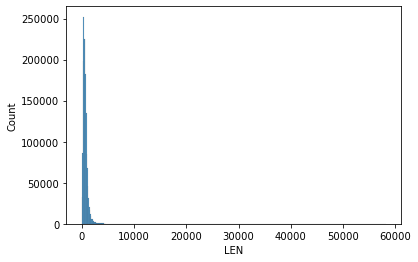

In [15]:
# Getting the distribution of travel time for all trips ********************
sns.histplot(data=df_tr, x="LEN", bins=500)
plt.show() 

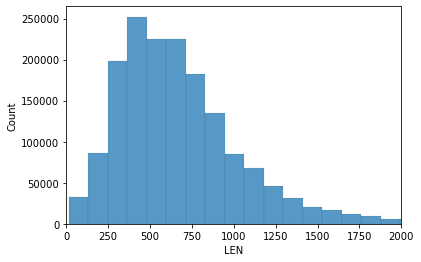

In [16]:
sns.histplot(data=df_tr, x="LEN", bins=500)
plt.xlim(0, 2000)
plt.show() # right skewed histogram->peak at around ~400

In [17]:
# lower_lim = df_tr['LEN'].quantile(0.01)
# upper_lim = df_tr['LEN'].quantile(0.99)
# capped_len = df_tr['LEN'].clip(lower_lim, upper_lim)
# df_tr["CLIPPED_LEN"] = pd.Series(capped_len, name='CLIPPED_LEN')
# df_tr.drop("CLIPPED_LEN", axis=1, inplace=True)
#compare_df = pd.DataFrame({'LEN': df_tr['LEN'], 'Winsorized LEN': winsorized_len})

In [18]:
df_tr.describe()

,TRIP_ID,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,LEN,YR,MON,DAY,HR,WK
count,1.674151e+06,362716.000000,797686.000000,1.674151e+06,1.674151e+06,1.674151e+06,1.674151e+06,1.674151e+06,1.674151e+06,1.674151e+06,1.674151e+06
mean,1.388600e+18,24492.082679,30.250048,2.000035e+07,1.388600e+09,7.320456e+02,2.013497e+03,6.592457e+00,1.559815e+01,1.191345e+01,3.057916e+00
std,9.191946e+15,19624.567796,17.736708,2.108916e+02,9.191946e+06,6.838430e+02,4.999904e-01,3.406837e+00,8.844500e+00,6.234943e+00,1.967695e+00
min,1.372637e+18,2001.000000,1.000000,2.000000e+07,1.372637e+09,1.500000e+01,2.013000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,1.380707e+18,6598.000000,15.000000,2.000017e+07,1.380707e+09,4.200000e+02,2.013000e+03,4.000000e+00,8.000000e+00,7.000000e+00,1.000000e+00
50%,1.388440e+18,18755.000000,27.000000,2.000034e+07,1.388440e+09,6.150000e+02,2.013000e+03,7.000000e+00,1.500000e+01,1.200000e+01,3.000000e+00
75%,1.396749e+18,40809.250000,49.000000,2.000052e+07,1.396749e+09,8.700000e+02,2.014000e+03,1.000000e+01,2.300000e+01,1.700000e+01,5.000000e+00
max,1.404173e+18,63884.000000,63.000000,2.000098e+07,1.404173e+09,5.820000e+04,2.014000e+03,1.200000e+01,3.100000e+01,2.300000e+01,6.000000e+00


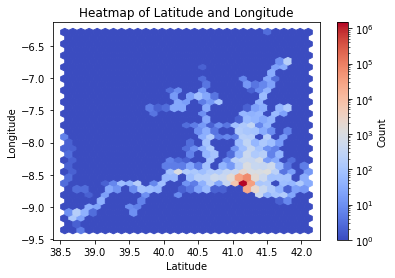

In [41]:
# Getting the distribution of trip position for some trips ********************
# First get latitude and logitude columns[
y = df_tr['POLYLINE']
coordinates = [ast.literal_eval(coord) for i, coord in enumerate(y) if i % 5 == 0]
flat_coordinates = [coord for sublist in coordinates for coord in sublist]

longitude = np.array([coord[0] for coord in flat_coordinates], dtype=float)
latitude = np.array([coord[1] for coord in flat_coordinates], dtype=float)

sample_size = len(df_tr)
indices = np.random.choice(len(latitude), size=sample_size, replace=False)
latitude_sample = latitude[indices]
longitude_sample = longitude[indices]

plt.hexbin(latitude_sample, longitude_sample, gridsize=30, cmap='coolwarm', bins='log')
plt.colorbar(label='Count')
plt.title('Heatmap of Latitude and Longitude')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

In [20]:
# checking statistics of various columns
df_tr["CALL_TYPE"].describe()

count     1674151
unique          3
top             B
freq       808889
Name: CALL_TYPE, dtype: object

In [21]:
unique = df_tr["ORIGIN_CALL"].nunique()
print(unique)

56929


In [22]:
unique = df_tr["ORIGIN_STAND"].nunique()
print(unique)

63


In [23]:
# Getting the number of NaN's in ORIGIN_STAND and ORIGIN_CALL
n = df_tr["ORIGIN_STAND"].isna().sum()
L = len(df_tr)
per = 100*(n/L)
print("ORIGIN_STAND column is {:.2f}% NaN".format(per)) # keep?
n = df_tr["ORIGIN_CALL"].isna().sum()
per = 100*(n/L)
print("ORIGIN_CALL column is {:.2f}% NaN".format(per)) # drop??

ORIGIN_STAND column is 52.35% NaN
ORIGIN_CALL column is 78.33% NaN


In [24]:
# Do One-hot encoding for CALL_TYPE column
df_tr = pd.get_dummies(df_tr, columns=['CALL_TYPE'], prefix=['CALL_TYPE'])

In [25]:
# unique number of years
df_tr["YR"].nunique() # most likely not useful, drop

2

In [26]:
# Getting a small sample for practice
# sample_size = 100000  
# df_sample = df_tr.sample(n=sample_size, random_state=42)  

In [27]:
# finding number of unique taxi_ID
# n = df_sample['TAXI_ID'].nunique()
# print("number of unique taxi_id:",n)

In [28]:
# df_tr['POLYLINE'] = df_tr['POLYLINE'].apply(ast.literal_eval)

# df_tr['GEOMETRY'] = df_tr['POLYLINE'].apply(lambda coords: LineString(coords))
# gdf = gpd.GeoDataFrame(df_tr, geometry='GEOMETRY')
# gdf['TRIP_DISTANCE'] = gdf['GEOMETRY'].length
# gdf['AVERAGE_SPEED'] = gdf['TRIP_DISTANCE'] / df_tr['LEN']
# print(gdf[['POLYLINE', 'GEOMETRY', 'TRIP_DISTANCE', 'AVERAGE_SPEED']])

In [29]:
df_tr["LEN"].describe()

count    1.674151e+06
mean     7.320456e+02
std      6.838430e+02
min      1.500000e+01
25%      4.200000e+02
50%      6.150000e+02
75%      8.700000e+02
max      5.820000e+04
Name: LEN, dtype: float64

In [30]:
# df_tr['LEN_log'] = np.log(df_tr['LEN'])
# df_tr["LEN_log"].describe()
# df_tr.drop('LEN_log', axis=1, inplace=True)

In [31]:
# new column for average trip time by taxi_ID
# df_sample['AVERAGE_LEN'] = df_sample.groupby('TAXI_ID')['LEN'].transform('mean')
df_tr['AVERAGE_LEN'] = df_tr.groupby('TAXI_ID')['LEN'].transform('mean')
#df_tr['AVERAGE_LEN'] = df_tr.groupby('TAXI_ID')['CLIPPED_LEN'].transform('mean')

In [32]:
# getting a dict of average trip time by taxi_ID
grouped_data = df_tr.groupby('TAXI_ID')['LEN'].mean()
#grouped_data = df_tr.groupby('TAXI_ID')['CLIPPED_LEN'].mean()
average_len_by_taxiID = grouped_data.to_dict()

/tmp/ipykernel_890/2426100216.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_tr.corr()


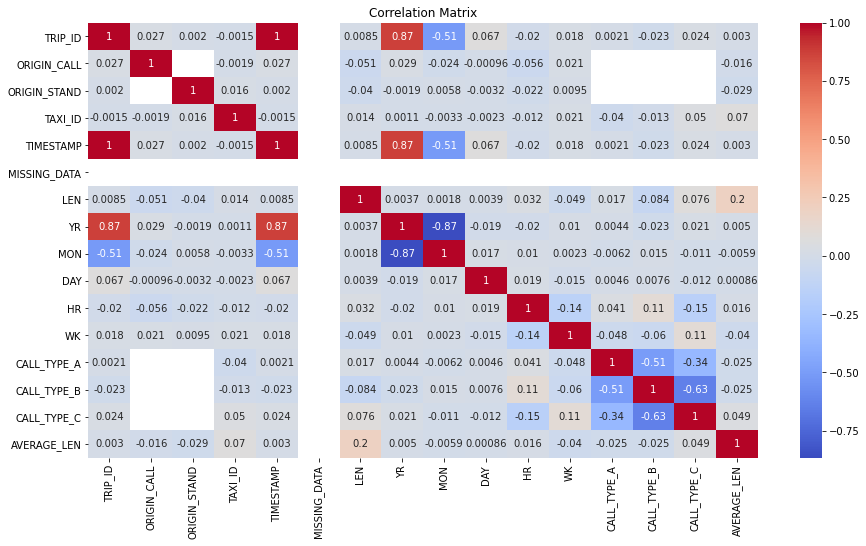

In [33]:
correlation_matrix = df_tr.corr()
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Model, Training, and Prediction

XGBoost

In [34]:
# Choosing features and getting train/validation split
features = ["CALL_TYPE_A", "CALL_TYPE_B", "CALL_TYPE_C","MON", "WK", "YR", "HR", "TAXI_ID", "AVERAGE_LEN",
            "ORIGIN_STAND"]
df_tr = df_tr.reset_index()
X = df_tr[features].values
y = df_tr['LEN'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.34, random_state=42)

In [35]:
%%time
# using XGBoost
# current best was using eta=0.01, max_depth=10, colsample_bytree=0.3, seed=42, n_estimators=10000
# validation rmse_loss record: 634.16 - predicting raw LEN,  test_size = 0.32
# test_size = 0.34/parameters listed above gave current best score on test -> (val_loss=634.77)(test_loss=719.8)
# increasing test size slightly improves performance on test set (more generalization)
# loss started increasing again at test_size = 0.35 and above

# validation rmse_loss record: 419.04 - predicting clipped LEN (0.01, 0.99),
# eta=0.05, max_depth=10, colsample_bytree=0.3, n_estimators=10000, seed=42

xgb_model = xgb.XGBRegressor(eta=0.01, max_depth=10, colsample_bytree=0.3, n_estimators=10000, 
                             eval_metric='rmse', early_stopping_rounds=10, seed=42, tree_method='gpu_hist')

xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

CPU times: user 25.8 s, sys: 10.4 s, total: 36.3 s
Wall time: 33.2 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, early_stopping_rounds=10,
             enable_categorical=False, eta=0.01, eval_metric='rmse',
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

# Milestone Report Q3

Validation RMSE: 634.77


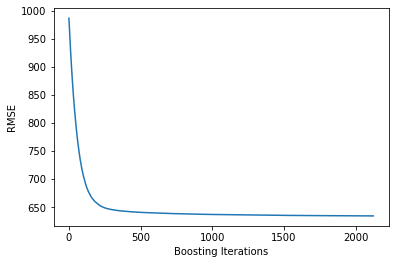

In [37]:
results = xgb_model.evals_result()
val_error = results['validation_0']['rmse']
print("Validation RMSE: {:.2f}".format(val_error[-1]))
plt.plot(range(len(val_error)), val_error)
plt.xlabel('Boosting Iterations')
plt.ylabel('RMSE')
plt.show()

In [ ]:
train_loss = results['validation_0']['rmse']
df_tr = df_tr.sample(frac=1, random_state=42)
train_indices = X_train[:, 0]
df_train_samples = df_tr.loc[train_indices]
top_loss_indices = np.argsort(train_loss)[::-1][:10]

plt.figure(figsize=(8, 6))
for i, index in enumerate(top_loss_indices):
    polyline_string = df_tr.at[index, "POLYLINE"]
    polyline = ast.literal_eval(polyline_string)
    lon_lat = np.array(polyline).T
    lon = lon_lat[0]
    lat = lon_lat[1]
    plt.plot(lon, lat, marker='o')

# Create the legend using the RMSE loss values
legend_labels = [f"Sample {i+1} (Loss: {train_loss[i]:.2f})" for i in top_loss_indices]
plt.legend(legend_labels)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Trips with Highest Training Loss')
plt.show()

In [ ]:
# loading test data
data = pd.read_csv("test_public.csv")

In [ ]:
# applying transformations
data[["YR", "MON", "DAY", "HR", "WK"]] = data[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")
data = pd.get_dummies(data, columns=['CALL_TYPE'], prefix=['CALL_TYPE'])
data['AVERAGE_LEN'] = data['TAXI_ID'].map(average_len_by_taxiID)
#lower_lim = data['AVERAGE_LEN'].quantile(0.01)
# upper_lim = data['AVERAGE_LEN'].quantile(0.99)
# capped_len = data['AVERAGE_LEN'].clip(lower_lim, upper_lim)
# data["AVERAGE_LEN"] = pd.Series(capped_len, name='capped_len')

In [ ]:
X_test2 = data[features].values
y_pred2 = xgb_model.predict(X_test2)

In [ ]:
# writing predicition to csv
df_sample = pd.read_csv("sampleSubmission.csv")
#y_pred2_inv = np.exp(y_pred2)
df_sample["TRAVEL_TIME"] = y_pred2
df_sample.to_csv("my_pred.csv", index=None)